# Clustering
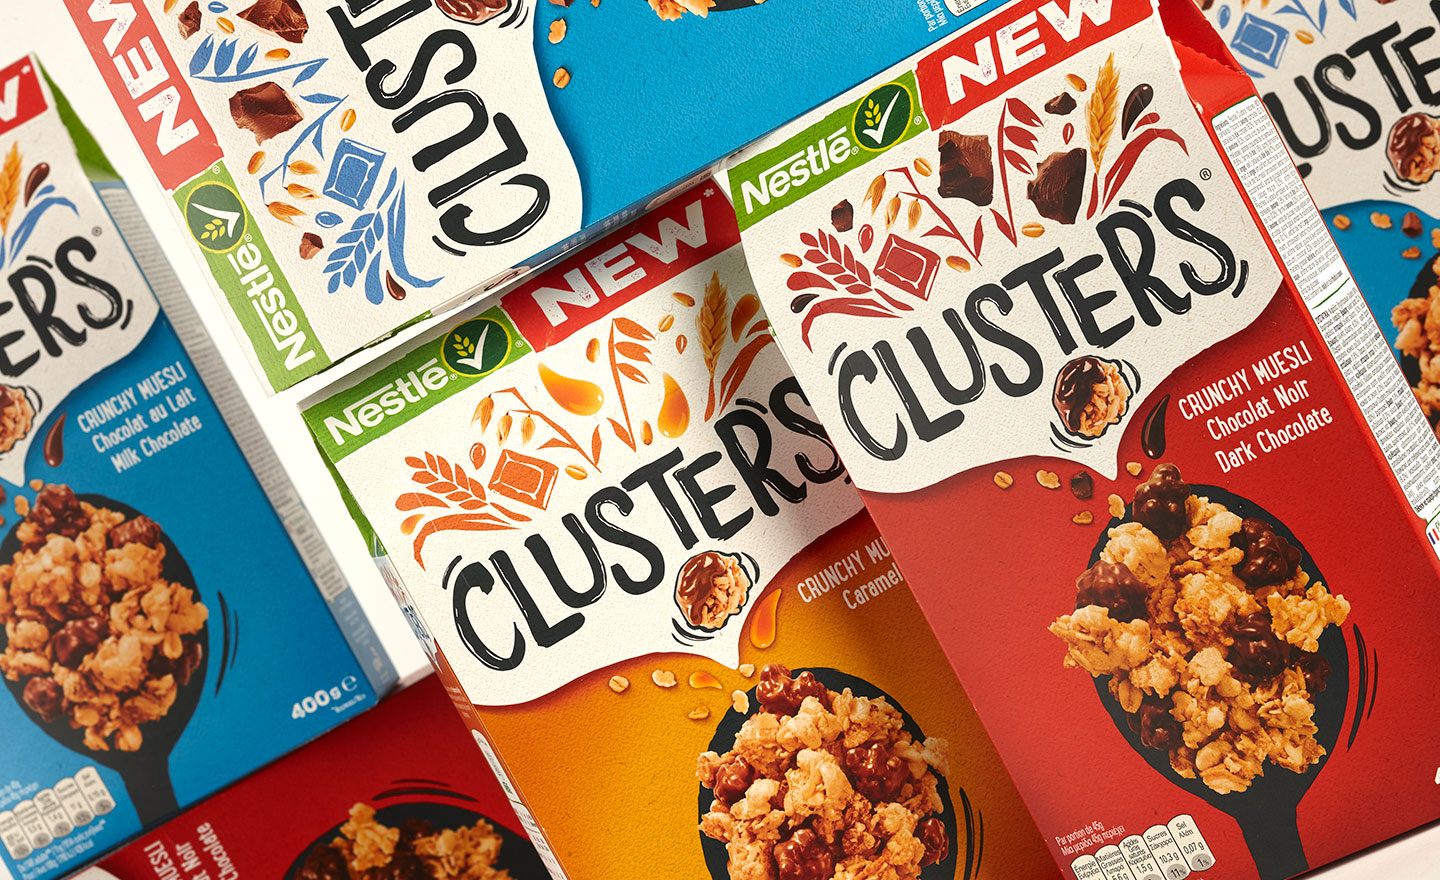

# Setup

In [1]:
!conda install hdbscan --yes

Solving environment: - 
  - https://repo.continuum.io/pkgs/main/osx-64::cvxcanon-0.1.1-py36h6440ff4_0
  - defaults::cvxcanon-0.1.1-py36h6440ff4done

# All requested packages already installed.



In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from collections import Counter

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.metrics import pairwise_distances_argmin
from sklearn.metrics import completeness_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import homogeneity_score
from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

import hdbscan
import yellowbrick
import yellowbrick.datasets
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance

# Data

## Random Blobs

In [3]:
X_blob, y_blob = make_blobs(n_samples = 500, centers = 5, cluster_std=1.5, random_state=538)

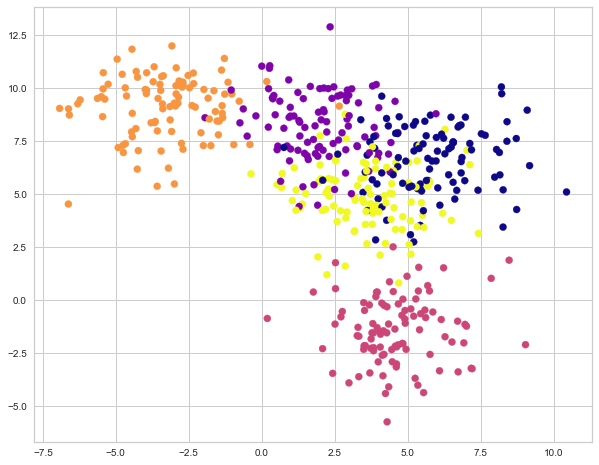

In [4]:
plt.figure(figsize=(10,8))
plt.scatter(X_blob[:,0], X_blob[:,1], s=50, c=y_blob, cmap='plasma')

# Metrics
* Supervised learning
    * Precision and Recall
    * Awkward to use these for Unsupervised learning
    * If you have the labels use Supervised
* What makes a good cluster?
    * High Intra-Cluster Similarity (cohesiveness within cluster)
    * Low Inter-Cluster Similarity (distinctiveness between clusters)

## Homogeneity
* Ground Truth is known
* Measures the degree to which each cluster has members of the same class
* 0.0 Poor - 1.0 Perfect

## Completeness
* Ground Truth is known
* Measures the degree to which all members of a given class are assigned to the same cluster
* 0.0 Poor - 1.0 Perfect

## Silhouette Coefficient
* Ground Truth not known
* a: Mean distance between sample & all other points in same class
* b: Mean distance between sample & all other points in the next nearest cluster

In [5]:
resultsDF = pd.DataFrame(columns=['Homogeneity', 'Completeness', 'Silhouette'])

def accuracy(X, labels, truth=None):
    score_silhouette   = silhouette_score(X, labels, metric='euclidean')
    print('Silhouette   : {:.3f}'.format(score_silhouette))
    
    score_homogeneity = None
    score_completeness = None
    if truth is not None:
        score_homogeneity  = homogeneity_score(labels, truth)
        score_completeness = completeness_score(labels, truth)   
        print('Homogeneity  : {:.3f}'.format(score_homogeneity))
        print('Completeness : {:.3f}'.format(score_completeness))
    
    return score_homogeneity, score_completeness, score_silhouette

def score_model(name, X, labels, truth):
    score = accuracy(X, labels, truth)
    resultsDF.loc[name] = [*score]

# KMeans
* Three main steps:
    * Pick initial centroids 
    * Iteratively
        * Assign points to closest centroid
        * Update centroids
    * Converge when centroids / labels do not change
* Workhorse of clustering

## EM Algorithm
* KMeans can be framed like Expectation Maximization (Lloyd's Algorithm)
* E = Assign to closes centroid
* M = Update centroids

In [6]:
def initialize(X, pick, seed):
    generator = np.random.seed(seed)
    indexes = np.random.choice(X.shape[0], pick, replace=False)
    return X[indexes]

def assignClusters(X, centroids):
    return pairwise_distances_argmin(X, centroids)
    
def computeCentroids(X, labels, clusters):
    return np.array( [X[labels == index].mean(0) for index in range(clusters)] )
    
def clusterData(X, clusters, seed=1337, iterations=50):
    iteration = 0
    converged = False
    centroids = initialize(X, clusters, seed)
    
    while not converged:
        assignment = assignClusters(X, centroids)
        updated    = computeCentroids(X, assignment, clusters)
        if np.all(centroids == updated) or iteration > iterations:
            converged = True
        centroids = updated
        iteration += 1
        
    return centroids, assignment

In [7]:
@interact
def ExpectationMax(EM_CLUSTERS=7):
    EM_centroids, EM_labels = clusterData(X_blob, EM_CLUSTERS)
    plt.figure(figsize=(10,8))
    plt.scatter(X_blob[:, 0], X_blob[:, 1], c=EM_labels, s=50, cmap='plasma')
    plt.scatter(EM_centroids[:, 0], EM_centroids[:, 1], s=100, c='gray')
    score_model('EM', X_blob, EM_labels, y_blob)

interactive(children=(IntSlider(value=7, description='EM_CLUSTERS', max=21, min=-7), Output()), _dom_classes=(…

## Sklearn

In [8]:
@interact
def SKLearnKMeans(SK_clusters=7):
    km = KMeans(n_clusters=SK_clusters)
    SK_labels = km.fit_predict(X_blob, y_blob)
    SK_centroids = computeCentroids(X_blob, SK_labels, SK_clusters)
    plt.figure(figsize=(10,8))
    plt.scatter(X_blob[:, 0], X_blob[:, 1], c=SK_labels, s=50, cmap='plasma')
    plt.scatter(SK_centroids[:, 0], SK_centroids[:, 1], s=100, c='gray')
    score_model('KMeans', X_blob, SK_labels, y_blob)

interactive(children=(IntSlider(value=7, description='SK_clusters', max=21, min=-7), Output()), _dom_classes=(…

## Limitations
* Costly computation O(kN), switch to MiniBatchKMeans for large datasets
* You need to know how many clusters (run the algorithm many times)
* Non-convex clusters are hard for KMeans to identify
* Guarantee to converge, but couold be in local minima (kmeans++)

## Selecting K
* When we have to provide the number of clusters, what's a good value?

### Elbow

In [9]:
@interact
def Elbow(Method=['distortion', 'silhouette', 'calinski_harabaz']):
    plt.figure(figsize=(10, 8))
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(2,12), metric=Method, locate_elbow=True)
    visualizer.fit(X_blob)

interactive(children=(Dropdown(description='Method', options=('distortion', 'silhouette', 'calinski_harabaz'),…

### Silhouette

In [10]:
@interact
def Elbow(Clusters=(2,10)):
    plt.figure(figsize=(10, 8))
    model = KMeans(Clusters)
    visualizer = SilhouetteVisualizer(model, colors='plasma')
    visualizer.fit(X_blob)

interactive(children=(IntSlider(value=6, description='Clusters', max=10, min=2), Output()), _dom_classes=('wid…

### Intercluster Distance Map

In [11]:
@interact
def Interdistance(Clusters=(2,10)):
    plt.figure(figsize=(10, 8))
    model = KMeans(Clusters)
    visualizer = InterclusterDistance(model, colors='plasma')
    visualizer.fit(X_blob)

interactive(children=(IntSlider(value=6, description='Clusters', max=10, min=2), Output()), _dom_classes=('wid…

# Heirarchical Clustering
* In contrast to a dividing, we can combine data into clusters
* Find two closes points or clusters and combine into a new cluster

In [12]:
@interact
def AGGLOMERATIVEInteractive(AGG_clusters=(2,10)):
    agg = AgglomerativeClustering(n_clusters=AGG_clusters)
    AGG_labels = agg.fit_predict(X_blob, y_blob)
    AGG_centroids = computeCentroids(X_blob, AGG_labels, AGG_clusters)
    plt.figure(figsize=(10,8))
    plt.scatter(X_blob[:, 0], X_blob[:, 1], c=AGG_labels, s=50, cmap='plasma')
    plt.scatter(AGG_centroids[:, 0], AGG_centroids[:, 1], s=100, c='gray')
    score_model('Agglomerative', X_blob, AGG_labels, y_blob)

interactive(children=(IntSlider(value=6, description='AGG_clusters', max=10, min=2), Output()), _dom_classes=(…

## Dendogram
* Scipy is slow - consider using fastcluster

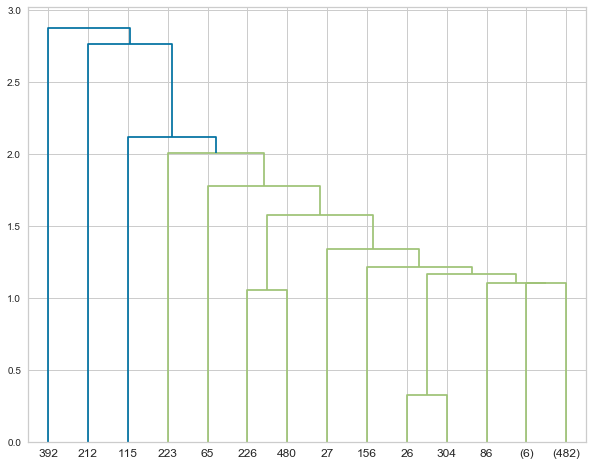

In [13]:
plt.figure(figsize=(10,8))
Z = linkage(X_blob)
out = dendrogram(Z, p=10, truncate_mode='level')

In [14]:
ZMatrix = pd.DataFrame(Z, columns = ['Cluster-1', 'Cluster-2', 'Distance', 'NewSize'])
ZMatrix

Cluster-1  Cluster-2  Distance  NewSize
0        294.0      447.0  0.015412      2.0
1        316.0      420.0  0.025203      2.0
2        232.0      461.0  0.025477      2.0
3         59.0      500.0  0.028027      3.0
4         74.0      299.0  0.033102      2.0
5        172.0      327.0  0.033387      2.0
6        188.0      259.0  0.035783      2.0
7         72.0      276.0  0.036286      2.0
8        311.0      418.0  0.036607      2.0
9         28.0       95.0  0.040854      2.0
10       239.0      473.0  0.040994      2.0
11       182.0      255.0  0.043212      2.0
12       121.0      203.0  0.045440      2.0
13       189.0      365.0  0.051487      2.0
14       455.0      489.0  0.055979      2.0
15         7.0      139.0  0.058173      2.0
16         2.0      415.0  0.059724      2.0
17        29.0      185.0  0.059848      2.0
18        70.0       90.0  0.060533      2.0
19        18.0      204.0  0.061279      2.0
20        47.0      155.0  0.061669      2.0
21       305.0      504.0  0.065263      3.0
22       113.0      409.0  0.067706      2.0
23       464.0      512.0  0.068160      3.0
24       231.0      456.0  0.068982      2.0
25       250.0      328.0  0.071779      2.0
26       288.0      366.0  0.071863      2.0
27       146.0      360.0  0.072511      2.0
28       343.0      522.0  0.073967      3.0
29       150.0      270.0  0.074889      2.0
..         ...        ...       ...      ...
469      153.0      942.0  0.774238      3.0
470      282.0      963.0  0.777043      6.0
471      854.0      968.0  0.793710    458.0
472      183.0      971.0  0.830629    459.0
473      381.0      949.0  0.837085      5.0
474      847.0      972.0  0.838270    462.0
475      955.0      974.0  0.839030    465.0
476      969.0      975.0  0.845553    468.0
477      334.0      976.0  0.851997    469.0
478      252.0      977.0  0.854380    470.0
479      973.0      978.0  0.855832    475.0
480      256.0      979.0  0.873805    476.0
481      346.0      980.0  0.880300    477.0
482       39.0      297.0  0.895196      2.0
483      197.0      982.0  0.951201      3.0
484      140.0      981.0  1.033528    478.0
485      983.0      984.0  1.036890    481.0
486      493.0      985.0  1.044117    482.0
487      226.0      480.0  1.054743      2.0
488      970.0      986.0  1.103273    488.0
489       86.0      988.0  1.106565    489.0
490      762.0      989.0  1.168233    491.0
491      156.0      990.0  1.216761    492.0
492       27.0      991.0  1.338512    493.0
493      987.0      992.0  1.576026    495.0
494       65.0      993.0  1.774596    496.0
495      223.0      994.0  2.009699    497.0
496      115.0      995.0  2.116127    498.0
497      212.0      996.0  2.763098    499.0
498      392.0      997.0  2.878704    500.0

[499 rows x 4 columns]

# Spectral Clustering
* Based in graphs
* Good when data in non-convex (irregular shapes)
* Slow (install pyamg package to speed up)
* Algorithm:
    * https://towardsdatascience.com/unsupervised-machine-learning-spectral-clustering-algorithm-implemented-from-scratch-in-python-205c87271045
    * Construct a similarity graph
    * Determine the Adjacency matrix
    * Determine the Degree matrix
    * Compute the Laplacian matrix (Degree - Adjacency)
    * Compute the eigenvectors of Lapacian
    * Use eigenvalues to find good number of clusters
    * Make cuts to the graph to find clusters 

In [15]:
@interact
def SPECTRALInteractive(CLUSTERS=(2,10)):
    spectral = SpectralClustering(n_clusters=CLUSTERS)
    SPECTRAL_labels = spectral.fit_predict(X_blob)
    SPECTRAL_centroids = computeCentroids(X_blob, SPECTRAL_labels, len(set(SPECTRAL_labels)))
    
    plt.figure(figsize=(10,8))
    plt.scatter(X_blob[:, 0], X_blob[:, 1], c=SPECTRAL_labels, s=50, cmap='plasma')
    plt.scatter(SPECTRAL_centroids[:, 0], SPECTRAL_centroids[:, 1], s=100, c='gray')
    
    score_model('Spectral', X_blob, SPECTRAL_labels, y_blob)

interactive(children=(IntSlider(value=6, description='CLUSTERS', max=10, min=2), Output()), _dom_classes=('wid…

# Density

## DBSCAN
* Density Based Spatial Clusting of Applications with Noise
    * Clusters can be any shape
    * Cluster is a set of core samples close to each other (Min Samples within EPS of eachother)
    * Cluster has a set of non-core samples that are close to a core sample
* Key Parameters
    * EPS = maximum distance for two points (core samples)
    * MIN_SAMPLES = minimum number of samples to be called a cluster
    * Low EPS or high MIN_SAMPLES indicates higher density
    * As you increase MIN_SAMPLES, the number of clusters tends to go down
    * If EPS is too low, you tend to see more outliers
* Deterministic
    * If the order of the data remains the same, the clusters will be identical
    * If order changes, the labels can change and samples "may" jump clusters
* Limitations
    * Setting EPS
    * Memory on large datasets (default = full pairwise similarity matrix)

In [16]:
@interact
def DBSCANInteractive(EPS=(0, 5.0), MIN_SAMPLES=(1,30)):
    warnings.filterwarnings('ignore')
    dbscan = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES)
    DBSCAN_labels = dbscan.fit_predict(X_blob)
    DBSCAN_centroids = computeCentroids(X_blob, DBSCAN_labels, len(set(DBSCAN_labels)))
    
    plt.figure(figsize=(10,8))
    plt.scatter(X_blob[:, 0], X_blob[:, 1], c=DBSCAN_labels, s=50, cmap='plasma')
    plt.scatter(DBSCAN_centroids[:, 0], DBSCAN_centroids[:, 1], s=100, c='gray')
    
    print('Clusters {}'.format(len(set(DBSCAN_labels))))
    score_model('DBSCAN', X_blob, DBSCAN_labels, y_blob)

interactive(children=(FloatSlider(value=2.5, description='EPS', max=5.0), IntSlider(value=15, description='MIN…

## HDBSCAN
* https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html
* Extension of DBSCAN using Heirarchical clustering

In [17]:
@interact
def HDBSCANInteractive(MIN_CLUSTER_SIZE=(30), MIN_SAMPLES=(30)):
    warnings.filterwarnings('ignore')
    hdb = hdbscan.HDBSCAN(min_cluster_size=MIN_CLUSTER_SIZE, 
                          min_samples=MIN_SAMPLES)
    HDBSCAN_labels = hdb.fit_predict(X_blob)
    HDBSCAN_centroids = computeCentroids(X_blob, HDBSCAN_labels, len(set(HDBSCAN_labels)))
    
    print('Clusters {}'.format(len(set(HDBSCAN_labels))))
    score_model('HDBSCAN', X_blob, HDBSCAN_labels, y_blob)
    
    plt.figure(figsize=(10,8))
    plt.scatter(X_blob[:, 0], X_blob[:, 1], c=HDBSCAN_labels, s=50, cmap='plasma')
    plt.scatter(HDBSCAN_centroids[:, 0], HDBSCAN_centroids[:, 1], s=100, c='gray')
    plt.show()
    
    plt.figure(figsize=(10,8))
    hdb.single_linkage_tree_.plot(cmap='plasma', p=10, truncate_mode='lastp')

interactive(children=(IntSlider(value=30, description='MIN_CLUSTER_SIZE', max=90, min=-30), IntSlider(value=30…

# Accuracy

In [18]:
@interact
def showResults(SORT=['Completeness', 'Homogeneity', 'Silhouette']):
    print(resultsDF.sort_values(SORT, ascending=False))

interactive(children=(Dropdown(description='SORT', options=('Completeness', 'Homogeneity', 'Silhouette'), valu…

# Clustering DataSets
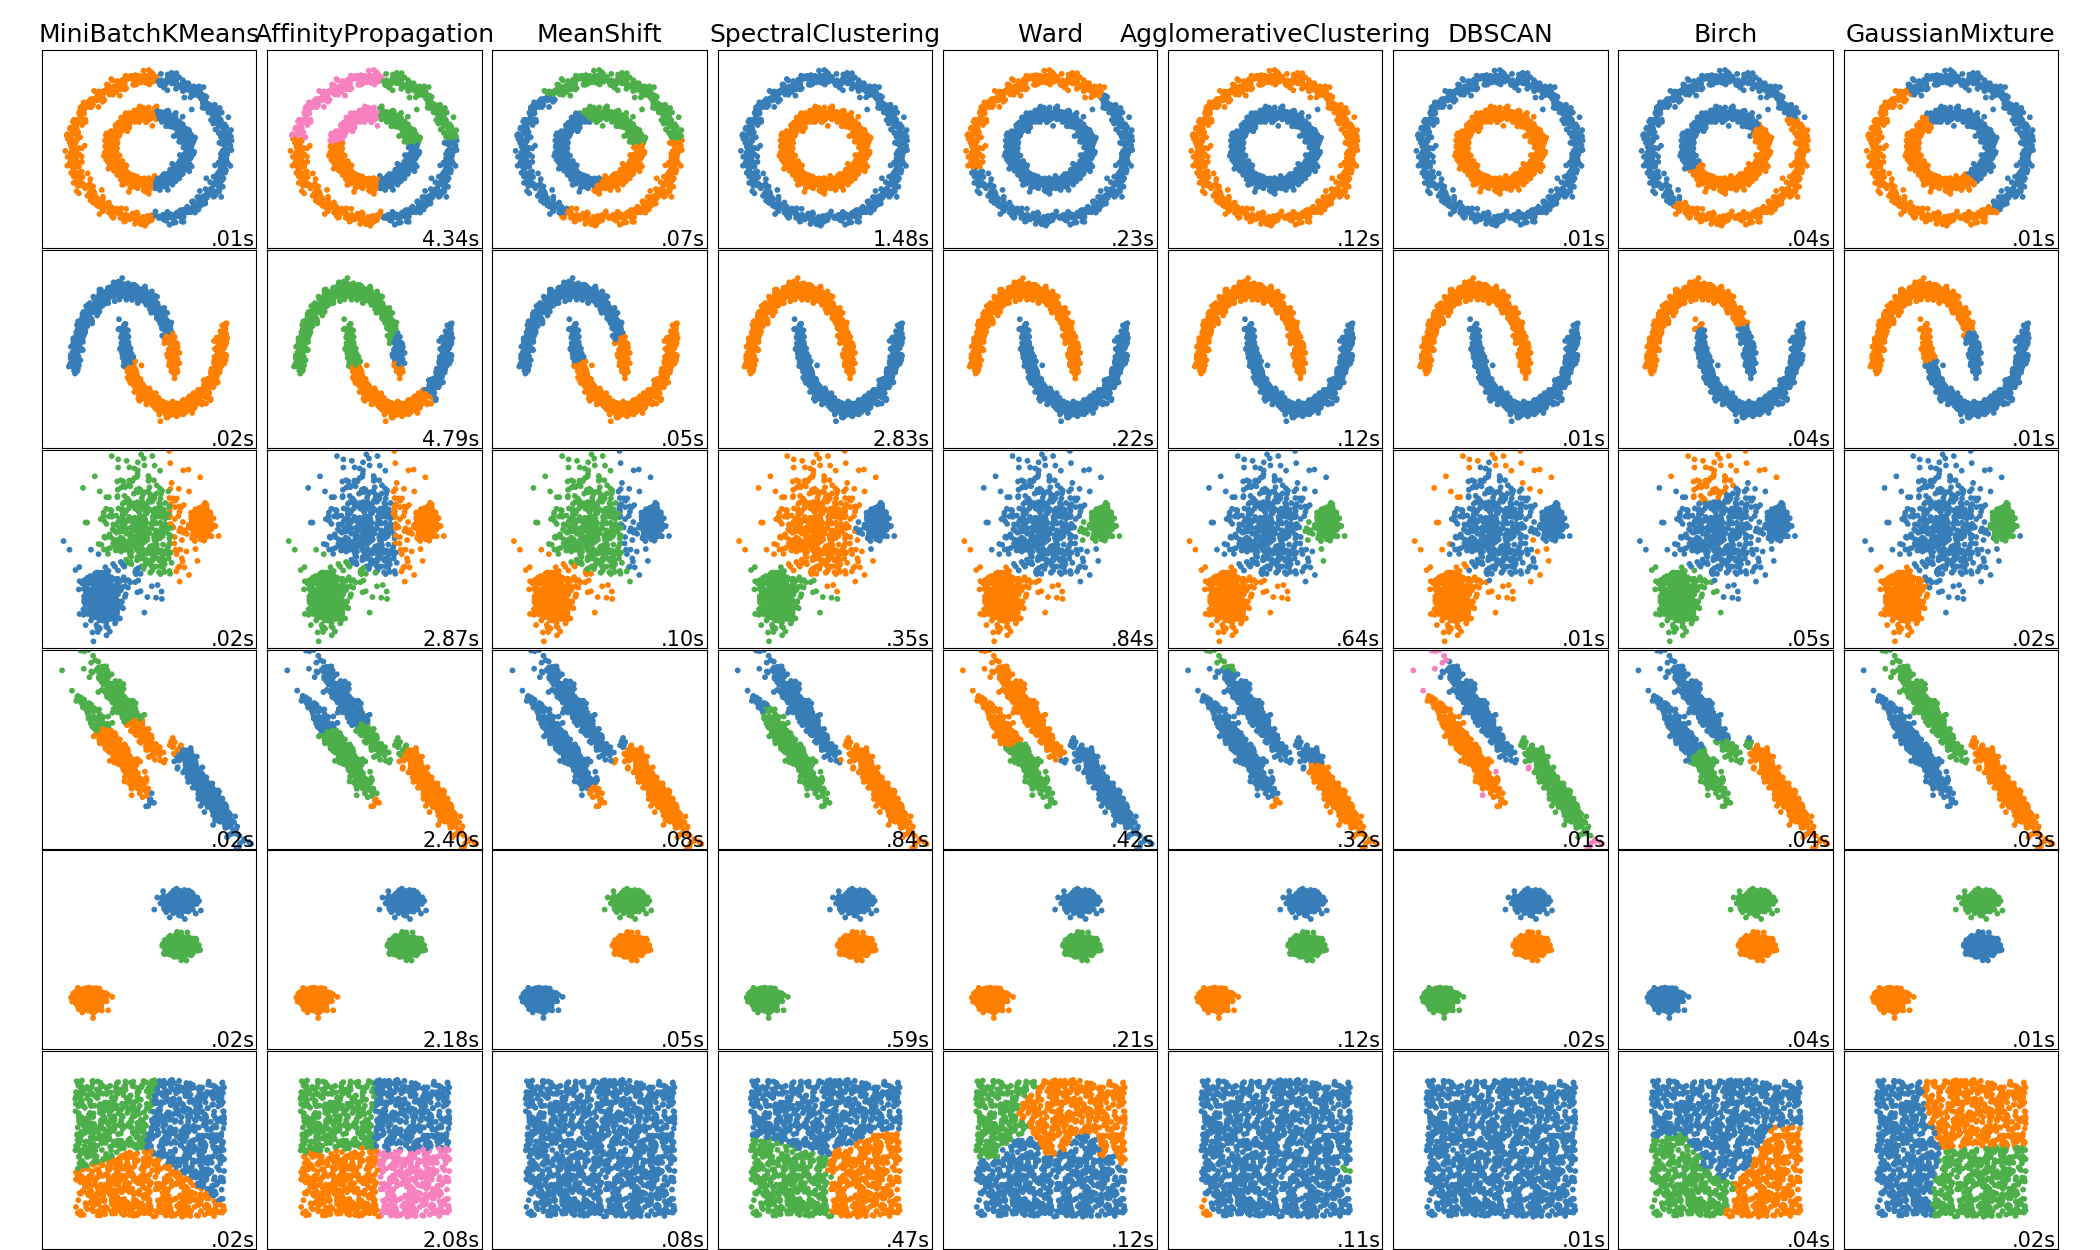

# Performance
* https://hdbscan.readthedocs.io/en/latest/performance_and_scalability.html
* Spectral, Affinity and Agglomerative usable under 10,000 data points
* Fastcluster extends the use of heirarchal clustering
* Scikit KMeans > scipy KMeans (requires # of clusters)
* HDBSCAN > DBSCAN (does not require # of clusters)

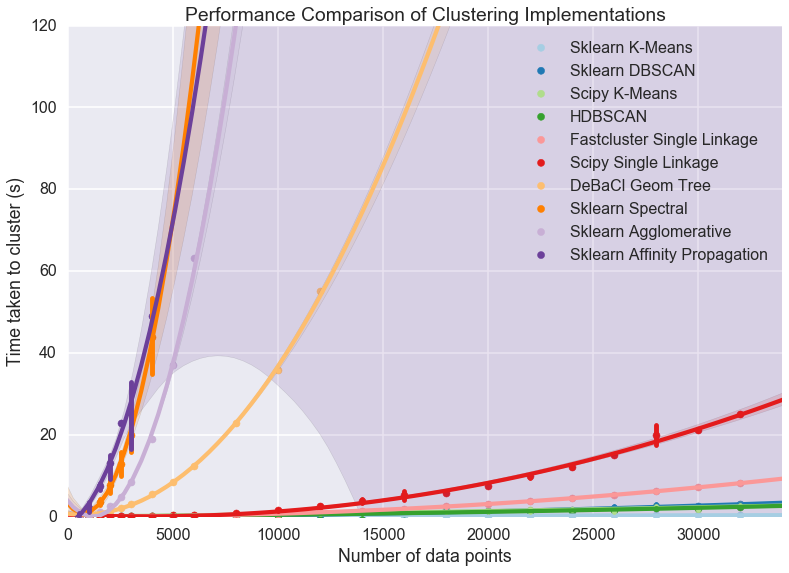

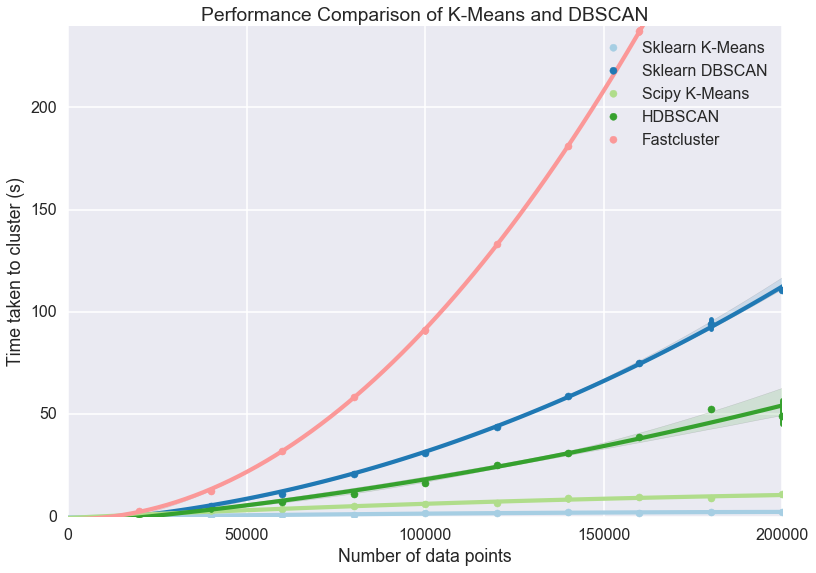

# Multiple Dimensions
* With multiple dimensions you're flying by instrument
* We'll use a credit dataset - 24 values
* Approach
    * Scale / Preprocess the Data
    * Check out # of Clusters
    * Fit & Score KMeans 
    * Visualize with PCA

## Load Data

In [21]:
credit = yellowbrick.datasets.load_credit()
creditDF = pd.DataFrame(credit)
creditDF.head()

limit  sex  edu  married   age  apr_delay  may_delay  jun_delay  \
0   20000.0  2.0  2.0      1.0  24.0        2.0        2.0       -1.0   
1  120000.0  2.0  2.0      2.0  26.0       -1.0        2.0        0.0   
2   90000.0  2.0  2.0      2.0  34.0        0.0        0.0        0.0   
3   50000.0  2.0  2.0      1.0  37.0        0.0        0.0        0.0   
4   50000.0  1.0  2.0      1.0  57.0       -1.0        0.0       -1.0   

   jul_delay  aug_delay   ...     jul_bill  aug_bill  sep_bill  apr_pay  \
0       -1.0       -2.0   ...          0.0       0.0       0.0      0.0   
1        0.0        0.0   ...       3272.0    3455.0    3261.0      0.0   
2        0.0        0.0   ...      14331.0   14948.0   15549.0   1518.0   
3        0.0        0.0   ...      28314.0   28959.0   29547.0   2000.0   
4        0.0        0.0   ...      20940.0   19146.0   19131.0   2000.0   

   may_pay  jun_pay  jul_pay  aug_pay  sep_pay  default  
0    689.0      0.0      0.0      0.0      0.0      1.0  
1   1000.0   1000.0   1000.0      0.0   2000.0      1.0  
2   1500.0   1000.0   1000.0   1000.0   5000.0      0.0  
3   2019.0   1200.0   1100.0   1069.0   1000.0      0.0  
4  36681.0  10000.0   9000.0    689.0    679.0      0.0  

[5 rows x 24 columns]

## Scale Data

In [22]:
scaler = StandardScaler()
creditDF = pd.DataFrame(scaler.fit_transform(creditDF), columns=creditDF.columns)

In [23]:
creditDF.head()

limit       sex       edu   married       age  apr_delay  may_delay  \
0 -1.136720  0.810161  0.185828 -1.057295 -1.246020   1.794564   1.782348   
1 -0.365981  0.810161  0.185828  0.858557 -1.029047  -0.874991   1.782348   
2 -0.597202  0.810161  0.185828  0.858557 -0.161156   0.014861   0.111736   
3 -0.905498  0.810161  0.185828 -1.057295  0.164303   0.014861   0.111736   
4 -0.905498 -1.234323  0.185828 -1.057295  2.334029  -0.874991   0.111736   

   jun_delay  jul_delay  aug_delay    ...     jul_bill  aug_bill  sep_bill  \
0  -0.696663  -0.666599  -1.530046    ...    -0.672497 -0.663059 -0.652724   
1   0.138865   0.188746   0.234917    ...    -0.621636 -0.606229 -0.597966   
2   0.138865   0.188746   0.234917    ...    -0.449730 -0.417188 -0.391630   
3   0.138865   0.188746   0.234917    ...    -0.232373 -0.186729 -0.156579   
4  -0.696663   0.188746   0.234917    ...    -0.346997 -0.348137 -0.331482   

    apr_pay   may_pay   jun_pay   jul_pay   aug_pay   sep_pay   default  
0 -0.341942 -0.227086 -0.296801 -0.308063 -0.314136 -0.293382  1.876378  
1 -0.341942 -0.213588 -0.240005 -0.244230 -0.314136 -0.180878  1.876378  
2 -0.250292 -0.191887 -0.240005 -0.244230 -0.248683 -0.012122 -0.532942  
3 -0.221191 -0.169361 -0.228645 -0.237846 -0.244166 -0.237130 -0.532942  
4 -0.221191  1.335034  0.271165  0.266434 -0.269039 -0.255187 -0.532942  

[5 rows x 24 columns]

## Elbow 

In [24]:
@interact
def CreditElbow(Method=['calinski_harabaz', 'distortion', 'silhouette']):
    plt.figure(figsize=(10, 8))
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(2,12), metric=Method, locate_elbow=True)
    visualizer.fit(creditDF)

interactive(children=(Dropdown(description='Method', options=('calinski_harabaz', 'distortion', 'silhouette'),…

## Run KMeans

In [25]:
km = KMeans(n_clusters=3)
clusters = km.fit_predict(creditDF)

In [26]:
cnt = Counter()
for x in clusters:
    cnt[x] += 1
cnt

Counter({0: 15840, 1: 3605, 2: 10555})

In [27]:
scores = accuracy(creditDF, clusters)

Silhouette   : 0.173


## Visualize with PCA

Text(0.5, 1.0, 'First 2 Principal Components - Credit (44.8% Variance Explained)')

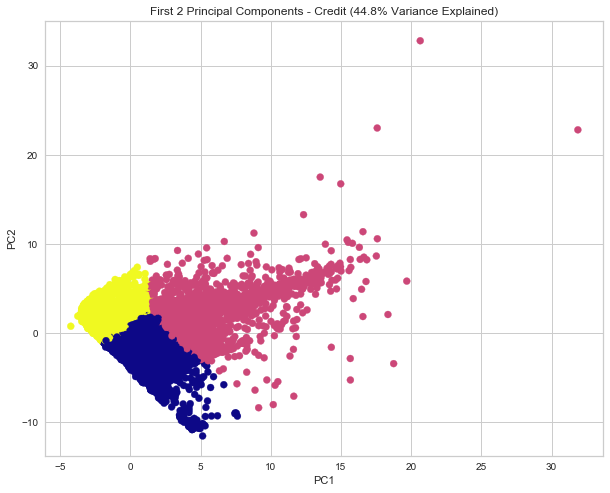

In [28]:
pca2d = PCA(n_components=2)
pcs = pd.DataFrame(pca2d.fit_transform(creditDF))
plotDF = pd.DataFrame(columns=['PC1', 'PC2', 'Cluster'])
plotDF['PC1'] = pcs[0]
plotDF['PC2'] = pcs[1]
plotDF['Cluster'] = clusters

plt.figure(figsize=(10,8))
plt.scatter(x=plotDF.PC1, y=plotDF.PC2, c=plotDF.Cluster, cmap='plasma')
plt.xlabel('PC1')
plt.ylabel('PC2')
percent_explained = sum(pca2d.explained_variance_ratio_) * 100.
plt.title('First 2 Principal Components - Credit ({:.1f}% Variance Explained)'.format(percent_explained))

## Explore Data

In [29]:
clusteredDF = creditDF.copy()
clusteredDF['cluster'] = clusters
grouping = clusteredDF.groupby('cluster').mean()
sizes    = clusteredDF.groupby('cluster').size()
grouping = grouping.reset_index()
grouping['size'] = sizes
grouping

cluster     limit       sex       edu   married       age  apr_delay  \
0        0 -0.477041 -0.044160  0.165379  0.082661 -0.104694   0.390632   
1        1  0.893367 -0.066614 -0.064070 -0.091132  0.166830   0.233806   
2        2  0.410776  0.089023 -0.226304 -0.092925  0.100136  -0.666080   

   may_delay  jun_delay  jul_delay  ...    aug_bill  sep_bill   apr_pay  \
0   0.497274   0.520549   0.522082  ...   -0.106122 -0.105287 -0.116845   
1   0.290846   0.297395   0.315921  ...    2.097616  2.048488  0.650016   
2  -0.845601  -0.882767  -0.891395  ...   -0.557171 -0.541644 -0.046658   

    may_pay   jun_pay   jul_pay   aug_pay   sep_pay   default   size  
0 -0.101657 -0.123626 -0.127345 -0.123352 -0.119399  0.121104  15840  
1  0.506192  0.570188  0.533736  0.530972  0.470172 -0.091846   3605  
2 -0.020329 -0.009218  0.008813  0.003765  0.018598 -0.150372  10555  

[3 rows x 26 columns]

In [30]:
difference = grouping.max(axis=0)-grouping.min(axis=0)
print(difference)

cluster          2.000000
limit            1.370408
sex              0.155636
edu              0.391683
married          0.175587
age              0.271525
apr_delay        1.056712
may_delay        1.342876
jun_delay        1.403317
jul_delay        1.413477
aug_delay        1.395369
sep_delay        1.331586
apr_bill         2.572310
may_bill         2.655522
jun_bill         2.671686
jul_bill         2.697800
aug_bill         2.654787
sep_bill         2.590132
apr_pay          0.766861
may_pay          0.607849
jun_pay          0.693814
jul_pay          0.661081
aug_pay          0.654324
sep_pay          0.589571
default          0.271476
size         12235.000000
dtype: float64


Text(0.5, 1.0, 'Clusters - July Bill & Credit Limit')

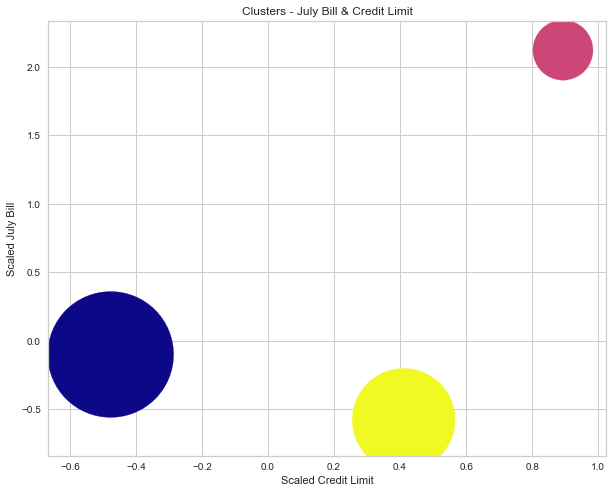

In [31]:
plt.figure(figsize=(10,8))
plt.scatter(x=grouping['limit'], y=grouping['jul_bill'], c=grouping['cluster'], cmap='plasma', s=grouping['size'])
plt.ylabel('Scaled July Bill')
plt.xlabel('Scaled Credit Limit')
plt.title('Clusters - July Bill & Credit Limit')

# Tips
* Be mindful of the dataset size
    * Small < 10,000 KMeans, (H)DBScan, Agglomerative(scipy, sklearn, fastecluster), Spectral & Affinity
    * Large > 10,000 KMeans, (H)DBScan, Agglomerative(fastcluster)
    * Very Large > 100,000 MiniBatchKMeans
* Know basic characteristics & weaknesses
    * KMeans
        * Know # clusters
        * Non-convex clusters
        * Mini-batch for huge datasets
        * Will converge - but could be a local minima
        * Use kmeans++ (ensures starting centroids are distant)
    * Agglomerative - Bottom up, generally builds good clusters, slow, use fastcluster
    * DBScan - Clusters of different densities (tuning EPS), Outliers
    * Spectral - Performs well, until you have 10k datapoints
* Other models
    * Scikit - 13 clustering models
    * Mean-Shift
    * EM - Guassian Mixture Model
* Multiple Dimensions
    * Visualize with PCA / T-SNE, MDS etc
* Uses
    * Outlier detection
    * Efficiently label data
    * Fraud
    * Customer analytics